In [140]:
library(magrittr)
library(tibble)
library(gutenbergr)
library(dplyr)
library(tidytext)
library(ggplot2)
library(tidyverse)

In [206]:
#downloading same titles in english and french
booksIdEn <- c(83, 103, 164, 1268, 1608, 1257, 965, 11656, 174, 887)
booksIdEnPlusOne <- c(84, 104, 165, 1269, 1609, 1258, 966, 11657, 175, 888)

booksIdFr <- c(799, 800, 5097, 14287, 2419, 19951, 26504, 13735, 14192, 51236)

#function for calculating heap law
heap <- function(booksId) {
    g <- gutenberg_works()
    v <- gutenberg_download(booksId) 
    books <- g[g$gutenberg_id %in% booksId,c("gutenberg_id","title")]
    v %<>% left_join(books) %>%
        mutate(gutenberg_id = NULL)

    heaps <- v %>%
        unnest_tokens(word, text) %>%
        group_by(title) %>% 
        mutate(M = row_number(), V = cumsum(!duplicated(word))) %>%
        summarise(a = lm(log10(V) ~ log10(M))$coefficients[1], b = lm(log10(V) ~ log10(M))$coefficients[2])
    return(heaps)
    
}


In [192]:
heapEn <- heap(booksIdEn)

Joining, by = "gutenberg_id"


In [207]:
heapEnPl <- heap(booksIdEnPlusOne) # zamiast francuskiego losowe id przesuniete o jeden

Joining, by = "gutenberg_id"


In [204]:
dfEn <- as.data.frame(heapEn) %>%
    add_column(language = "en")
dfFr <- as.data.frame(heapEnPl) %>%
    add_column(language = "fr")
df <- rbind(dfEn, dfFr)
df

title,a,b,language
<chr>,<dbl>,<dbl>,<chr>
Around the World in Eighty Days,0.7394671,0.6532877,en
Camille (La Dame aux Camilias),1.0612123,0.5454732,en
"From the Earth to the Moon; and, Round the Moon",0.9548350,0.6068525,en
Intentions,0.6856043,0.6769286,en
The Black Tulip,0.8978457,0.6039249,en
The Great Shadow and Other Napoleonic Tales,0.7409080,0.6288367,en
The Mysterious Island,1.0906852,0.5520328,en
The Picture of Dorian Gray,0.7400915,0.6347603,en
The Three Musketeers,1.2600071,0.5193619,en


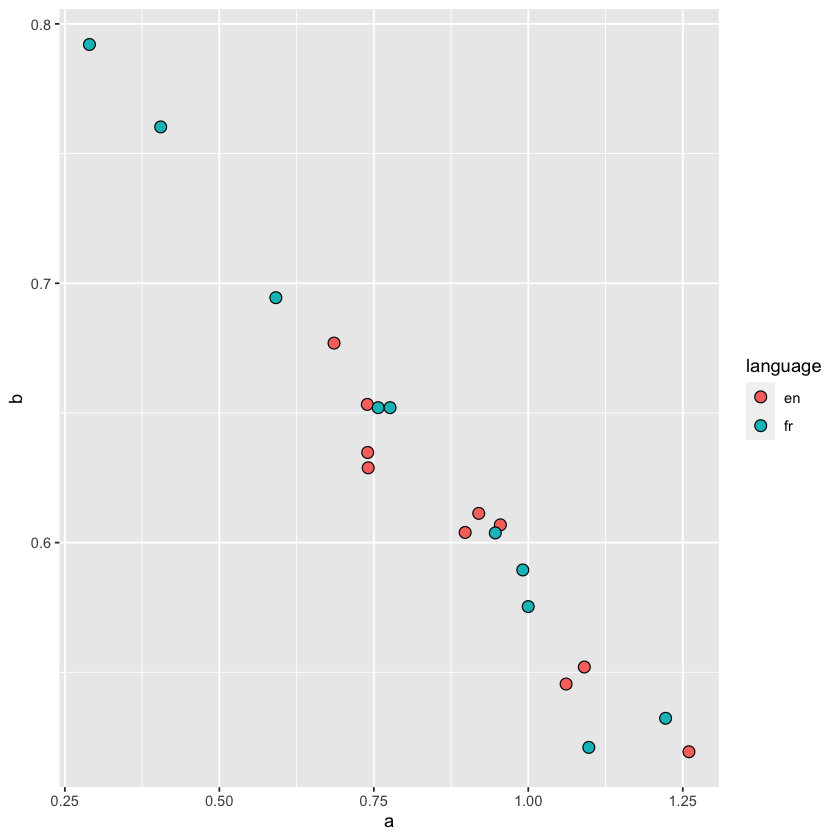

In [205]:
ggplot(df) +
geom_point(aes(x = a, y = b, fill = language), size =3, shape=21)


Po kilku godzinach niestety ustawienie języka francuskiego nie udało się - wyświetlenie tytułu francuskiego nie działa + niektóre książki mają złe formatowanie, wiem że do dziś jest deadline ale spróbowałbym wyjaśnić to na konsultacjach

In [172]:
#converting latin1 to utf-8
heapFr <- function(booksId) {
    g <- gutenberg_works()
    v <- gutenberg_download(booksId) 
    books <- g[g$gutenberg_id %in% booksId,c("gutenberg_id","title")]
    v %<>% left_join(books) %>%
        mutate(gutenberg_id = NULL) %>% 
    map( iconv , from = "ISO-8859-1", to = "UTF-8") %>%
    as.tibble()

    heaps <- v %>%
        unnest_tokens(word, text) %>%
        group_by(title) %>% 
        mutate(M = row_number(), V = cumsum(!duplicated(word))) %>%
        summarise(a = lm(log10(V) ~ log10(M))$coefficients[1], b = lm(log10(V) ~ log10(M))$coefficients[2])
    return(heaps)
    
}
booksIdFrUtf <- c(5097, 14287, 2419, 13951, 13735, 51236)
booksIdFrLatin <- c(799, 800, 26504, 14192)

g <- gutenberg_works()
v <- gutenberg_download(booksIdFrUtf) 
books <- g[g$gutenberg_id %in% booksIdFrUtf,c("gutenberg_id","title")]
v %<>% left_join(books) %>%
    mutate(gutenberg_id = NULL) 
books

    # heaps <- v %>%
    #     unnest_tokens(word, text) %>%
    #     group_by(title) %>% 
    #     mutate(M = row_number(), V = cumsum(!duplicated(word))) %>%
    #     summarise(a = lm(log10(V) ~ log10(M))$coefficients[1], b = lm(log10(V) ~ log10(M))$coefficients[2])

Joining, by = "gutenberg_id"


gutenberg_id,title
<int>,<chr>


In [186]:
int <- 5097
g[g$gutenberg_id==5097, c("gutenberg_id","title")]

gutenberg_id,title
<int>,<chr>
